# Jonathan Halverson
# Saturday, February 10, 2018
# Clustering in Spark 2

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
import numpy as np
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Wine classification").getOrCreate()

In [3]:
wine_raw = spark.read.csv('../../machine_learning/wine.csv', inferSchema=True)
wine_raw = wine_raw.withColumn('_c0', wine_raw._c0 - 1)
wine_raw = wine_raw.withColumn('_c5', wine_raw['_c5'].cast('double'))
wine_raw = wine_raw.withColumn('_c13', wine_raw['_c13'].cast('double'))
wine = wine_raw.withColumnRenamed('_c0', 'label')

In [4]:
wine.show(3)

+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+------+
|label|  _c1| _c2| _c3| _c4|  _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|  _c13|
+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+------+
|    0|14.23|1.71|2.43|15.6|127.0| 2.8|3.06|0.28|2.29|5.64|1.04|3.92|1065.0|
|    0| 13.2|1.78|2.14|11.2|100.0|2.65|2.76|0.26|1.28|4.38|1.05| 3.4|1050.0|
|    0|13.16|2.36|2.67|18.6|101.0| 2.8|3.24| 0.3|2.81|5.68|1.03|3.17|1185.0|
+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+------+
only showing top 3 rows



In [5]:
wine_raw.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)



In [6]:
cols = wine.columns
cols.remove('label')

In [7]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=cols, outputCol="features")
df = vecAssembler.transform(wine)
df.show()

+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+------+--------------------+
|label|  _c1| _c2| _c3| _c4|  _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|  _c13|            features|
+-----+-----+----+----+----+-----+----+----+----+----+----+----+----+------+--------------------+
|    0|14.23|1.71|2.43|15.6|127.0| 2.8|3.06|0.28|2.29|5.64|1.04|3.92|1065.0|[14.23,1.71,2.43,...|
|    0| 13.2|1.78|2.14|11.2|100.0|2.65|2.76|0.26|1.28|4.38|1.05| 3.4|1050.0|[13.2,1.78,2.14,1...|
|    0|13.16|2.36|2.67|18.6|101.0| 2.8|3.24| 0.3|2.81|5.68|1.03|3.17|1185.0|[13.16,2.36,2.67,...|
|    0|14.37|1.95| 2.5|16.8|113.0|3.85|3.49|0.24|2.18| 7.8|0.86|3.45|1480.0|[14.37,1.95,2.5,1...|
|    0|13.24|2.59|2.87|21.0|118.0| 2.8|2.69|0.39|1.82|4.32|1.04|2.93| 735.0|[13.24,2.59,2.87,...|
|    0| 14.2|1.76|2.45|15.2|112.0|3.27|3.39|0.34|1.97|6.75|1.05|2.85|1450.0|[14.2,1.76,2.45,1...|
|    0|14.39|1.87|2.45|14.6| 96.0| 2.5|2.52| 0.3|1.98|5.25|1.02|3.58|1290.0|[14.39,1.87,2.45,...|
|    0|14.06|2.15|2.

In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df_std = scaler_model.transform(df).cache()
df_std.select('features', 'scaledFeatures').show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[14.23,1.71,2.43,...|[1.51434076729214...|
|[13.2,1.78,2.14,1...|[0.24559682781702...|
|[13.16,2.36,2.67,...|[0.19632521851701...|
|[14.37,1.95,2.5,1...|[1.68679139984215...|
|[13.24,2.59,2.87,...|[0.29486843711702...|
+--------------------+--------------------+
only showing top 5 rows



Below we compute the within set sum of squared errors for each k-value:

In [9]:
from pyspark.ml.clustering import KMeans

errors =  []
k_clusters = range(2, 11)
for k in k_clusters:
     kmeans = KMeans(k=k, initSteps=25, seed=42, featuresCol='scaledFeatures', initMode="k-means||")
     model = kmeans.fit(df_std)
     WSSSE = model.computeCost(df_std)
     errors.append(WSSSE)

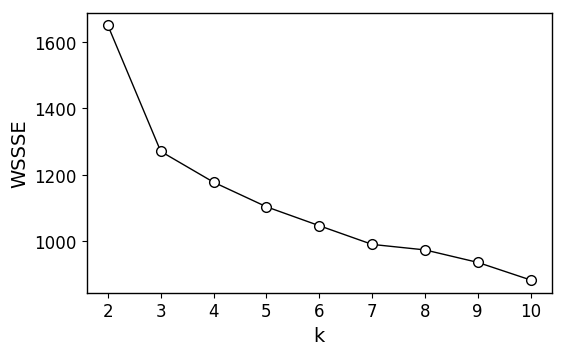

In [10]:
plt.plot(k_clusters, errors, 'k-', marker='o', mfc='w')
plt.xlabel('k')
plt.ylabel('WSSSE')

Using the elbow method, we conclude that there are 3 clusters. This is confirmed by the data set.

In [11]:
kmeans = KMeans(k=3, seed=42, featuresCol='scaledFeatures', initMode="k-means||")
model = kmeans.fit(df_std)
model.clusterCenters()

[array([-0.92346686, -0.39293312, -0.49312571,  0.17012195, -0.49032869,
        -0.07576891,  0.02075402, -0.03343924,  0.05810161, -0.89937699,
         0.46050459,  0.27000254, -0.75172566]),
 array([ 0.83288262, -0.30295508,  0.36368014, -0.60847486,  0.57596208,
         0.88274724,  0.975069  , -0.56050853,  0.57865427,  0.17058229,
         0.47265036,  0.77705513,  1.1220202 ]),
 array([ 0.16444359,  0.86909545,  0.18637259,  0.52289244, -0.07526047,
        -0.97657548, -1.21182921,  0.72402116, -0.77751312,  0.93889024,
        -1.16151216, -1.28877614, -0.40594284])]